In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from pathlib import Path


# remove duplicate entries from csv data
nonships_meta = pd.read_csv(Path("/content/drive/MyDrive/OTH/space-eye/dataset/nonshipsAIS_2017_Zone17.csv"))
nonships_meta = nonships_meta.drop_duplicates(subset="newindex")
nonships_meta = nonships_meta.set_index('newindex', verify_integrity=True)

ships_meta = pd.read_csv(Path("/content/drive/MyDrive/OTH/space-eye/dataset/shipsAIS_2017_Zone17.csv"))
ships_meta = ships_meta.drop_duplicates(subset="newindex")
ships_meta = ships_meta.set_index('newindex', verify_integrity=True)

In [3]:
from pathlib import Path

data_dir = Path("/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped")

In [4]:
nonships_count = len(list(data_dir.glob('nonships/*')))
ships_count = len(list(data_dir.glob('ships/*')))

ships_count, nonships_count

(872, 880)

In [5]:
!pip install -q rasterio

In [6]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

#load files
X_data = list()
y_data = list()
index_data = list()


for classifier in ["ships", "nonships"]:
  classifier_dir = os.path.join(data_dir, classifier)
  for item in Path(classifier_dir).glob("*.tif"):
    src_filename = item.stem
    src_index = int(src_filename.split('_')[-1])

    print(item)
    
    # load data
    src_ds = rasterio.open(item)
    data = src_ds.read()
    X_data.append(data)
    y_data.append(1 if classifier == "ships" else 0)
    index_data.append(src_index)

X_data = np.asarray(X_data)
y_data = np.asarray(y_data)
index_data = np.asarray(index_data)

# changing the axis order
X_data = X_data.swapaxes(1,3).swapaxes(1,2)


/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_1.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_3.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_0.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_2.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_4.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_8.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_9.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_11.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_10.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_6.tif
/content/drive/MyDrive/OTH/space-eye/dataset/flattened_cropped/ships/ships_image_7.tif
/content/drive/MyDrive/OTH/space-eye/data

In [7]:
X_data.shape, y_data.shape

((1752, 400, 400, 4), (1752,))

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_test, X_validate, y_test, y_validate = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

#tif data is in uint16 which is not supported for data augmentation
X_train = tf.cast(X_train, tf.int32)
X_test = tf.cast(X_test, tf.int32)
X_validate = tf.cast(X_validate, tf.int32)

#remove NIR channel
X_train = X_train[:,:,:,:-1]
X_test = X_test[:,:,:,:-1]
X_validate = X_validate[:,:,:,:-1]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))

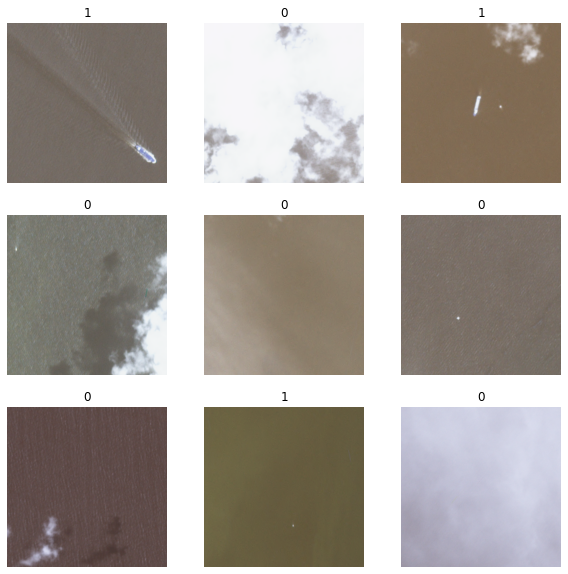

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [10]:
#size = (150, 150)

#train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
#validation_dataset = validation_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
#test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, size), y))

In [11]:
batch_size = 32

train_dataset = train_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(buffer_size=10)
validation_dataset = validation_dataset.cache().batch(batch_size).prefetch(buffer_size=10)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

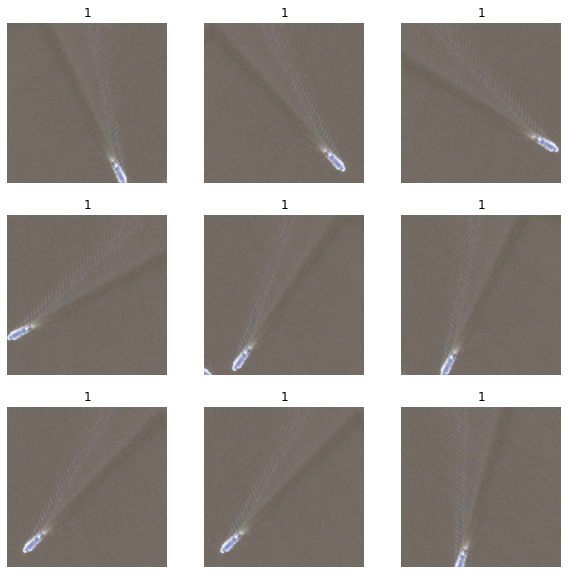

In [13]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [14]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(400, 400, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(400, 400, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 xception (Functional)       (None, 13, 13, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [15]:
import keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), f1_m, keras.metrics.Precision(), keras.metrics.Recall()],
)

epochs = 20
model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/20
44/44 [==============================] - 21s 316ms/step - loss: 0.6418 - binary_accuracy: 0.6595 - f1_m: 0.6066 - precision: 0.6889 - recall: 0.5665 - val_loss: 0.6343 - val_binary_accuracy: 0.6705 - val_f1_m: 0.6554 - val_precision: 0.7260 - val_recall: 0.5824
Epoch 2/20
44/44 [==============================] - 12s 268ms/step - loss: 0.6084 - binary_accuracy: 0.7102 - f1_m: 0.6955 - precision: 0.7115 - recall: 0.6951 - val_loss: 0.6090 - val_binary_accuracy: 0.6932 - val_f1_m: 0.6770 - val_precision: 0.7534 - val_recall: 0.6044
Epoch 3/20
44/44 [==============================] - 12s 268ms/step - loss: 0.5846 - binary_accuracy: 0.7281 - f1_m: 0.7187 - precision: 0.7257 - recall: 0.7225 - val_loss: 0.5893 - val_binary_accuracy: 0.7102 - val_f1_m: 0.6972 - val_precision: 0.7703 - val_recall: 0.6264
Epoch 4/20
44/44 [==============================] - 12s 270ms/step - loss: 0.5627 - binary_accuracy: 0.7516 - f1_m: 0.7421 - precision: 0.7493 - recall: 0.7471 - val_loss: 0.5730 - 

In [17]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 xception (Functional)       (None, 13, 13, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred.round().astype(int), pos_label=1, average="binary")

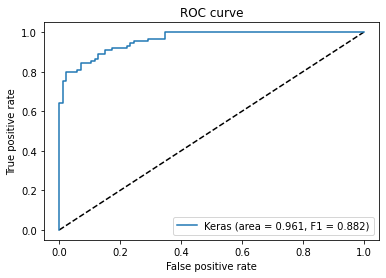

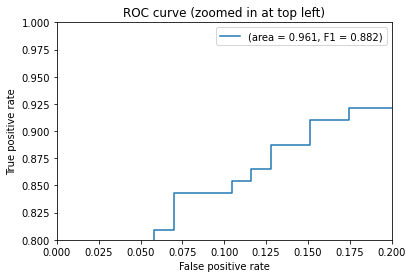

In [20]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f}, F1 = {:.3f})'.format(auc, f1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(area = {:.3f}, F1 = {:.3f})'.format(auc, f1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()